In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as f

import random
from itertools import count
import gc

%matplotlib inline

In [2]:
env = gym.make('CartPole-v1')
env

<TimeLimit<CartPoleEnv<CartPole-v1>>>

In [3]:
state = env.reset()
done = False
reward_sum = 0
while not done:
    next_state, reward, done, _ = env.step(np.random.randint(env.action_space.n))
    reward_sum += reward
    env.render()

env.close()
print(f'Total reward for random agent {reward_sum}')

Total reward for random agent 17.0


# Policy Gradient - PG

PG is a type of policy optimizations where instead of optimizaing Q function, Policy is optimized directly


In [4]:
class Net(nn.Module):

    def __init__(self, inputs, outputs, dim=(128, 256), device='cpu'):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(inputs, dim[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(dim)-1):
            self.hidden_layers.append(nn.Linear(dim[i], dim[i+1]))

        self.out = nn.Linear(dim[-1], outputs)
        self.device = torch.device(device)
        self.to(self.device)

    def forward(self, X):
        X = self._move(X)
        X = f.relu(self.fc1(X))
        for l in self.hidden_layers:
            X = f.relu(l(X))

        return self.out(X)

    def _move(self, X):
        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X,
                             device=self.device,
                             dtype=torch.float32)
            X = X.unsqueeze(0)

        return X


net = Net(env.observation_space.shape[0], env.action_space.n)
net


Net(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=128, out_features=256, bias=True)
  )
  (out): Linear(in_features=256, out_features=2, bias=True)
)

Running training on cuda:0 device


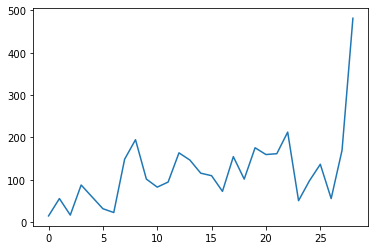

In [5]:
from torch.distributions import Categorical

batch_size = 5000
net = Net(env.observation_space.shape[0], env.action_space.n, device='cuda:0' if torch.cuda.is_available() else 'cpu')
optimizer = torch.optim.RMSprop(net.parameters(), lr=0.001)
total_rewards = []

print(f'Running training on {net.device} device')
for i in range(50):
    # One epoch
    observations = []
    actions = []
    rewards = []
    weights = []

    obs = env.reset()

    # collect experiences
    while True:
        observations.append(obs)
        
        logits = net(obs)
        action = Categorical(logits=logits).sample().item()
        obs, reward, done, _ = env.step(action)
        actions.append(action)
        rewards.append(reward)

        if done:
            r, l = sum(rewards), len(rewards)
            # print('Sum of episode rewards', r)
            weights += [r] * l

            # reset vars
            obs, done, rewards = env.reset(), False, []

            if len(observations) > batch_size:
                total_rewards.append(r)
                break
        
    if total_rewards[-1] > 480:
        # early stop
        break

    optimizer.zero_grad()
    # loss
    logits = net(observations)
    logp = Categorical(logits=logits).log_prob(torch.as_tensor(actions, dtype=torch.float32, device=net.device))
    batch_loss = -(logp * torch.as_tensor(weights, dtype=torch.float32, device=net.device)).mean()
    batch_loss.backward()
    optimizer.step()

    gc.collect()

plt.plot(total_rewards)

In [6]:
avg_reward = []

for i in range(5):
    state = env.reset()
    done = False
    reward_sum = 0
    while not done:
        logits = net(state)
        action = Categorical(logits=logits).sample().item()
        next_state, reward, done, _ = env.step(action)
        state = next_state
        reward_sum += reward
        env.render()

    avg_reward.append(reward_sum)

env.close()
print(f'Total reward for random agent {np.mean(avg_reward)}')

Total reward for random agent 294.8
